# CPSC 330 Lecture 13

#### Lecture plan

- Announcements
-
-
- Break (5 min)
- Feature correlations (5 min)
- Feature selection: intro (5 min)
- Feature selection: importance-based feature elimination (15 min)
- Feature selection: Lasso (10 min)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.feature_selection import RFE, RFECV

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
import seaborn as sns

# TODO

drop=first issue, mention this as *optional*

- Say you have categories A,B,C,D
- you drop='first'
- so then you have B,C,D and 0,0,0 means A.
- Then you feature select out D
- Now you have B,C
- but now 0,0 means A or D.
- That's weird. ?

## Announcements

## Break (5 min)

## Feature correlations (10 min)

(This should probably have gone in the feature importances lecture, L10.)

- We'll look at the correlations between various features with other features and the target (first row/column). 
- What is correlation, in simple terms:
  - If $Y$ goes up when $X$ goes up, we say $X$ and $Y$ are positively correlated.
  - If $Y$ goes down when $X$ goes up, we say $X$ and $Y$ are negatively correlated.
  - If $Y$ is unchanged when $X$ changes, we say $X$ and $Y$ are uncorrelated.

In [37]:
cor = pd.concat((y_train, X_train_enc),axis=1).iloc[:,:20].corr();

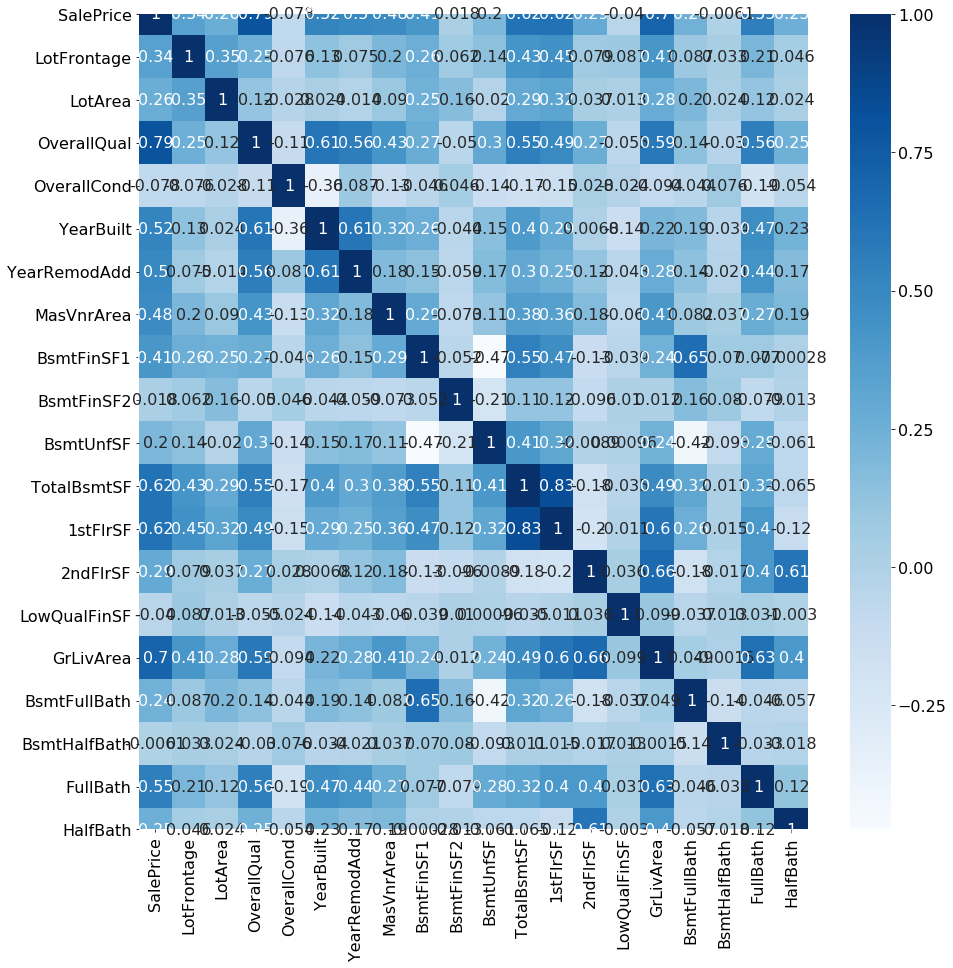

In [38]:
plt.figure(figsize=(15,15))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

Note: we got similar diagrams from `pandas_profiler`. 

- We can immediately see that `SalePrice` is highly correlated with `OverallQual`.
- This is an early hint that `OverallQual` is a useful feature in predicting `SalePrice`.
- However, this approach is **extremely simplistic**.
  - It only looks at each feature in isolation.
  - It only looks at linear associations:
    - What if `SalePrice` is high when `BsmtFullBath` is 2 or 3, but low when it's 0, 1, or 4? They might seem uncorrelated.

- Looking at this diagram also tells us the relationship between features. 
  - For example, `1stFlrSF` and `TotalBsmtSF` are highly correlated. 
  - Do we need both of them?
  - If our model says `1stFlrSF` is very important and `TotalBsmtSF` is very unimportant, do we trust those values?
  - Maybe `TotalBsmtSF` only "becomes important" if `1stFlrSF` is removed.
  - Sometimes the opposite happens: a feature only becomes important if another feature is _added_.

## Feature selection intro (5 min)

- What is feature selection?
- Find the features	(columns) $X$ that are important for predicting	$y$, and remove the features that aren't. 
- Very related to looking at feature importances.

In [39]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Which of these features are useful?

Why we might want to ask this? Why not just use all of them, even the fairly unimportant ones?

- Data collection: What type of new data should I collect? It may be cheaper to collect fewer columns.
- Computation: Models fit/predict faster with fewer columns.
- Fundamental tradeoff: Can I reduce overfitting by removing useless features?
  - Think about the random noise column in hw5.
  - What does it do to training error?
  - What does it do to validation error?

How to do feature selection? The main approaches I will recommend in this course:

1. Domain knowledge
2. Importance-based feature elimination
3. Lasso


## Feature selection: importance-based feature elimination (15 min)

- We already had a whole lecture on feature importances.
- Let's use these importances to eliminate unimportant features (i.e., those with low importance).
- Basic idea: throw away the least important feature.

#### Recursive feature elimination 

1. Decide $k$, the number of features to select. 
2. Assign importances to features, e.g. by fitting a model and looking at `coef_` or `feature_importances_`.
3. Remove the least important feature.
4. Repeat steps 2-3 until only $k$ features are remaining.

Note that this is **not** the same as just removing the $d-k$ least importance features in one shot!

In scikit-learn, we'll do this using `RFE`:

In [40]:
from sklearn.feature_selection import RFE

Let's look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html).

In [41]:
len(X_train_enc.columns)

288

In [42]:
model = Ridge(alpha=100)
model.fit(X_train_enc, y_train_log);
model.score(X_train_enc, y_train_log)

0.8963159928298279

In [43]:
model.score(X_valid_enc, y_valid_log)

0.8913218700485418

Select the top 30 features, one at a time, based on the absolute value of `model.coef_`:

In [44]:
rfe = RFE(model, n_features_to_select=30)
rfe.fit(X_train_enc, y_train_log);

In [45]:
rfe.score(X_train_enc, y_train_log)

0.871404215578216

In [46]:
rfe.score(X_valid_enc, y_valid_log)

0.8790758548429103

The model wasn't overfitting, so feature selection didn't help here.

In [47]:
selected_columns = X_train_enc.columns[rfe.support_]
selected_columns

Index(['OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'ExterQual', 'BsmtQual', 'KitchenQual', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_NridgHt', 'SaleCondition_Abnorml',
       'BedroomAbvGr_4', 'Foundation_PConc', 'CentralAir_N', 'CentralAir_Y',
       'Condition1_Norm', 'BldgType_1Fam', 'BldgType_Twnhs',
       'LotConfig_CulDSac', 'GarageType_Attchd', 'MSZoning_RL', 'MSZoning_RM',
       'BsmtExposure_Gd', 'BsmtFinType1_Unf'],
      dtype='object')

In [48]:
rfe.ranking_ # may be different than the ranked feature importances!

array([113,  44,   1,   1,   1,  57, 134,  95,  78, 173,   1,   1,   1,
       212,   1,   3, 177,  13,  14,   1,   1, 126,   1,  45,  19, 171,
        94,  77,  20,  72, 205,  62,   1, 231,   1,  98,   8,   1,  91,
        15,  56, 140, 114, 108,  38, 119, 152,   1,   1,  60,  25,  29,
       111, 226, 165, 103,  28,   1,  82, 154, 141, 104,   4,   7, 129,
       131,  17, 133,  61,  47, 124, 158, 153, 210, 244,  18, 254,  54,
       255, 130, 230, 179, 161,  85,  88,   1, 200, 216,  63,  23,  24,
         5,  31, 127, 197, 203, 149,  50,  89, 246, 235, 132, 249, 120,
         2, 128, 107, 259,  34, 142, 228,  21,  79,  96, 185, 218,  84,
       121, 122,   1,  67, 213, 229, 252, 224, 217, 189, 146,  52, 182,
        35,  68,  26, 178, 150, 247, 112, 211, 170, 222, 139,  70, 223,
       215,  49, 137,  97, 102,  59, 163,   1, 118, 250,  12,  30, 206,
         1,   1,  99,  33,   1, 183, 106,  81, 199, 207, 240,   9,   6,
       236, 208,  41, 145,  40, 237, 164, 257, 243, 180,  11,  9

We can do this same thing with a random forest. `RFE` will automatically use the random forests's `feature_importances_` instead of linear regression's `coef_`.

In [49]:
model = RandomForestRegressor(random_state=123, max_depth=5, n_estimators=10)
model.fit(X_train_enc, y_train_log);
model.score(X_train_enc, y_train_log)

0.8973724704274202

In [50]:
model.score(X_valid_enc, y_valid_log)

0.7853203109013847

In [51]:
rfe = RFE(model, n_features_to_select=100)
rfe.fit(X_train_enc, y_train_log);

In [52]:
rfe.score(X_train_enc, y_train_log)

0.8980900982024065

In [53]:
rfe.score(X_valid_enc, y_valid_log)

0.7942045812793544

- In this case the model was overfitting and feature selection helped a tiny bit.
- But we may have achieved the same by tuning hyperparameters.

What about categorical features?

In [56]:
selected_columns = X_train_enc.columns[rfe.support_]
selected_columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'PoolArea', 'MiscVal',
       'YrSold', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
       'KitchenQual', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'PavedDrive_N', 'SaleType_COD', 'MasVnrType_BrkCmn',
       'MasVnrType_BrkFace', 'SaleCondition_Abnorml', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Partial', 'LandContour_Bnk',
       'LandContour_Lvl', 'Exterior1st_VinylSd', 'BedroomAbvGr_3',
       'GarageFinish_RFn', 'Kitc

In [58]:
removed_columns = [col for col in X_train_enc.columns if col not in selected_columns]
removed_columns;

- Does it make sense that we removed `BldgType_Duplex` but kept `BldgType_1Fam`?
  - Discuss for 1-2 minutes.
  
<br><br><br><br><br><br>

- To me, this seems strange, because these are OHE categories of the same `BldgType` feature.
- There are more sophisticated ways of selecting categorical features.
- This seems to be unresolved in sklearn: https://github.com/scikit-learn/scikit-learn/issues/8480
  - There should be a way around this using `Pipeline`, I will look into this more.

#### How to choose the number of features to select?

- Suppose you don't know the number of relevant features in advance, 
- You can find them using cross validation with [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)
  - You would definitely not want to use training error! (Why?)

In [59]:
model = Ridge(alpha=100)

rfe_cv = RFECV(model, cv=5)
rfe_cv.fit(X_train_enc, y_train_log)
print('Number of selected features: %d/%d' % (rfe_cv.n_features_, X_train_enc.shape[1]))
# print('Feature mask:', rfe_cv.support_)

Number of selected features: 218/288


- It stopped once it got to 218 features.
- Dropping down to 217 would lower the cross-validation score.
  - This is similar to using cross-validation to tune a hyperparameter.
  - Indeed, the number of selected features _is_ a hyperparameter.

Note: Here we have the same Golden Rule issue, it's a bit of a hassle to fix (may return to this time-permitting).

## Feature selection: Lasso (10 min)

- We have been using `Ridge` for linear regression.
- Another type of linear regression is implemented in `Lasso`.
  - Like `Ridge`, but sets some coefficients **exactly to zero** instead of just small:

In [60]:
from sklearn.linear_model import Lasso

In [61]:
lr = Lasso(alpha=0.01) # 1000 works for un-log
lr.fit(X_train_enc, y_train_log);

In [62]:
lr_coefs = pd.DataFrame(data=lr.coef_, index=X_train_enc.columns, columns=["Coefficient"])
lr_coefs.sort_values(by="Coefficient", ascending=False)

,Coefficient
OverallQual,0.131847
GrLivArea,0.079946
GarageCars,0.059096
YearBuilt,0.056509
OverallCond,0.039899
...,...
BedroomAbvGr_1,-0.000000
BedroomAbvGr_2,-0.000000
BedroomAbvGr_3,0.000000
Fence_MnWw,0.000000


In [63]:
lr_coefs_abs = pd.DataFrame(data=np.abs(lr.coef_), index=X_train_enc.columns, columns=["Coefficient"])
lr_coefs_abs.sort_values(by="Coefficient", ascending=False)

,Coefficient
OverallQual,0.131847
GrLivArea,0.079946
GarageCars,0.059096
YearBuilt,0.056509
OverallCond,0.039899
...,...
BedroomAbvGr_0,0.000000
BedroomAbvGr_1,0.000000
BedroomAbvGr_2,0.000000
BedroomAbvGr_3,0.000000


- It sets the coefficients of a bunch of features to zero.
- These features are being ignored.
- Thus, Lasso is performing feature selection.

In [64]:
np.sum(lr.coef_ != 0)

24

In [65]:
np.sum(np.abs(lr.coef_) > 1e-8)

24

In [66]:
len(lr.coef_)

288

In [67]:
# alphas = [1,3, 10, 30, 100, 300, 1000, 3000]
alphas = 10.0**np.arange(-5,-1.5,0.5)
train_scores = []
valid_scores = []
num_selected = []
for alpha in alphas:
    lr = Lasso(alpha=alpha, max_iter=10_000)
    lr.fit(X_train_enc, y_train_log);
    train_scores.append(lr.score(X_train_enc, y_train_log))
    valid_scores.append(lr.score(X_valid_enc, y_valid_log))
    num_selected.append(np.sum(lr.coef_ != 0))
    

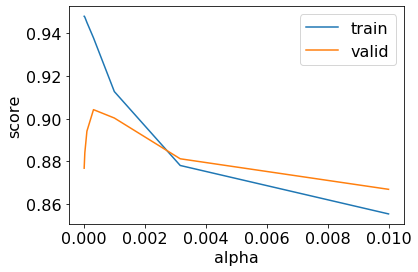

In [68]:
plt.plot(alphas, train_scores, label="train");
plt.plot(alphas, valid_scores, label="valid");
plt.legend();
plt.xlabel('alpha');
plt.ylabel('score');

Here we can see the overfitting on the left, when we select more features.

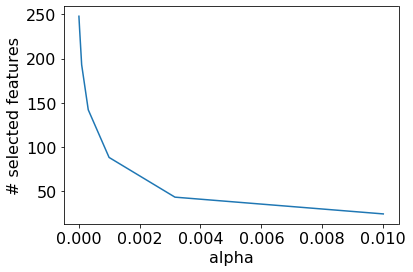

In [69]:
plt.plot(alphas, num_selected);
plt.xlabel('alpha');
plt.ylabel('# selected features');

(Reminder: in sklearn `alpha=1/C`.)

#### Warnings about feature selection 

- A feature's relevance is only defined in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- If features can be predicted from other other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 
- Is feature selection completely hopeless?
    - It is messy but we still want to do it. So we try to do our best! 
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$ for the data you have.

(If we have time left, we can do the True/False questions from last class.)